In [1]:
import pandas as pd
import keras
import numpy as np

# Import CIFAR 10 dataset
from keras.datasets import cifar10

from keras.preprocessing.image import ImageDataGenerator

# Import Necessary CNN Building Blocks
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU

from keras import backend as K
from keras import applications
from keras import callbacks
from keras import optimizers
from keras.utils import np_utils
import random

import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = 9,6

In [2]:
# Requirements:
# !pip install keras
# !pip install tensorflow
# !pip install keras
# !pip install tensorflow_addons

# TODO: data augmentation validation

# <span style='font-family:Georgia'> Data loading & preparation

In [3]:
# Load Dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

BATCH_SIZE = 32
INPUT_SHAPE = X_train.shape[1:]
NUM_CLASSES = 10

print('x_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [4]:
# Normalize input data
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# Encode target variable
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

# <span style='font-family:Georgia'> Deep Learning pretrained models fitting

## <span style='font-family:Georgia'> Residual Network (ResNet)

In [5]:
LR = 2e-5
EPOCHS=10
INPUT_SHAPE = X_train.shape[1:]

In [6]:
input_tensor=tf.keras.Input(shape=INPUT_SHAPE)

In [7]:
res_base = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    
resNet = Sequential()
resNet.add(res_base)
resNet.add(tf.keras.layers.Flatten())
resNet.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))

In [8]:
resNet.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.RMSprop(learning_rate=LR),
               metrics=['accuracy'])

In [9]:
resNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
resNet.fit(X_train,
           y_train,
           batch_size=BATCH_SIZE,
           epochs=EPOCHS,
           shuffle=True,
           verbose=1,
           validation_data=(X_test, y_test_ohe)
          )

Epoch 1/10
1563/1563 [==============================] - 2162s 1s/step - loss: 1.9117 - accuracy: 0.4027 - val_loss: 1.3854 - val_accuracy: 0.5737
Epoch 2/10
1563/1563 [==============================] - 1917s 1s/step - loss: 1.0692 - accuracy: 0.6375 - val_loss: 0.9771 - val_accuracy: 0.6832
Epoch 3/10
1563/1563 [==============================] - 1822s 1s/step - loss: 0.8132 - accuracy: 0.7246 - val_loss: 0.8772 - val_accuracy: 0.7212
Epoch 4/10
1563/1563 [==============================] - 1815s 1s/step - loss: 0.6594 - accuracy: 0.7782 - val_loss: 0.8060 - val_accuracy: 0.7413
Epoch 5/10
1563/1563 [==============================] - 1719s 1s/step - loss: 0.5403 - accuracy: 0.8166 - val_loss: 0.8210 - val_accuracy: 0.7579
Epoch 6/10
1563/1563 [==============================] - 1832s 1s/step - loss: 0.4525 - accuracy: 0.8464 - val_loss: 0.8189 - val_accuracy: 0.7694
Epoch 7/10
1563/1563 [==============================] - 1961s 1s/step - loss: 0.3693 - accuracy: 0.8742 - val_loss: 0.8690 -

## <span style='font-family:Georgia'> VGG16

In [11]:
EPOCHS=10
BATCH_SIZE = 32
LR=1e-3
MOMENTUM=0.9
INPUT_SHAPE = X_train.shape[1:]

In [12]:
vgg_base = tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet',input_shape=INPUT_SHAPE)

vgg = Sequential()
vgg.add(vgg_base)
vgg.add(Flatten()) 
vgg.add(Dense(NUM_CLASSES, activation=('softmax')))
vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14,719,818
Trainable params: 14,719,818
Non-trainable params: 0
_________________________________________________________________


In [13]:
vgg.compile(loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.SGD(learning_rate=LR, momentum=MOMENTUM),
            metrics=['accuracy'])

In [14]:
vgg_history = (
    vgg.fit(X_train,
            y_train, 
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
            validation_data=(X_test, y_test_ohe),
            validation_steps=X_test.shape[0]//BATCH_SIZE,
            verbose=1
           )
)

Epoch 1/10
1562/1562 [==============================] - 1521s 973ms/step - loss: 0.1767 - accuracy: 0.6279 - val_loss: 0.1355 - val_accuracy: 0.7251
Epoch 2/10
1562/1562 [==============================] - 1557s 997ms/step - loss: 0.1193 - accuracy: 0.7589 - val_loss: 0.1139 - val_accuracy: 0.7740
Epoch 3/10
1562/1562 [==============================] - 1577s 1s/step - loss: 0.1022 - accuracy: 0.7959 - val_loss: 0.1066 - val_accuracy: 0.7882
Epoch 4/10
1562/1562 [==============================] - 1563s 1s/step - loss: 0.0913 - accuracy: 0.8200 - val_loss: 0.0967 - val_accuracy: 0.8065
Epoch 5/10
1562/1562 [==============================] - 1565s 1s/step - loss: 0.0823 - accuracy: 0.8363 - val_loss: 0.0912 - val_accuracy: 0.8209
Epoch 6/10
1562/1562 [==============================] - 1587s 1s/step - loss: 0.0744 - accuracy: 0.8545 - val_loss: 0.0945 - val_accuracy: 0.8071
Epoch 7/10
1562/1562 [==============================] - 1574s 1s/step - loss: 0.0686 - accuracy: 0.8658 - val_loss: 0.

# <span style='font-family:Georgia'> Models Evaluation

## <span style='font-family:Georgia'> Residual Network (ResNet)

In [15]:
resNet.evaluate(X_test, y_test_ohe)

313/313 [==============================] - 24s 78ms/step - loss: 1.0104 - accuracy: 0.7790


[1.0103892087936401, 0.7789999842643738]

In [16]:
y_pred_resnet = resNet.predict(X_test)

In [17]:
y_pred_resnet_classes = np.argmax(y_pred_resnet, axis=-1)

In [18]:
conf_matr_resnet = pd.DataFrame(confusion_matrix(y_test, y_pred_resnet_classes))
conf_matr_resnet.to_csv("conf_matr_resnet.csv")
conf_matr_resnet

,0,1,2,3,4,5,6,7,8,9
0,821,17,29,15,23,4,6,8,48,29
1,21,861,4,9,2,4,9,3,24,63
2,42,3,699,66,91,30,42,17,7,3
3,20,9,44,630,55,151,49,19,8,15
4,13,1,35,51,746,34,43,51,10,16
5,11,4,28,174,44,675,18,41,3,2
6,5,6,33,64,24,20,838,7,2,1
7,10,3,19,37,47,49,5,815,4,11
8,50,28,6,14,8,4,2,4,860,24
9,21,74,6,13,2,5,3,8,23,845


In [19]:
print(classification_report(y_test, y_pred_resnet_classes))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1000
           1       0.86      0.86      0.86      1000
           2       0.77      0.70      0.73      1000
           3       0.59      0.63      0.61      1000
           4       0.72      0.75      0.73      1000
           5       0.69      0.68      0.68      1000
           6       0.83      0.84      0.83      1000
           7       0.84      0.81      0.83      1000
           8       0.87      0.86      0.86      1000
           9       0.84      0.84      0.84      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



## <span style='font-family:Georgia'> VGG16

In [20]:
vgg.evaluate(X_test, y_test_ohe)

313/313 [==============================] - 41s 131ms/step - loss: 0.0824 - accuracy: 0.8397


[0.08236587047576904, 0.8396999835968018]

In [21]:
y_pred_vgg16 = vgg.predict(X_test)

In [22]:
y_pred_vgg16_classes = np.argmax(y_pred_vgg16, axis=-1)

In [23]:
conf_matr_vgg = pd.DataFrame(confusion_matrix(y_test, y_pred_vgg16_classes))
conf_matr_vgg.to_csv("conf_matr_vgg.csv")
conf_matr_vgg

,0,1,2,3,4,5,6,7,8,9
0,885,7,21,12,10,0,3,10,28,24
1,10,918,1,2,1,1,1,2,7,57
2,39,2,829,36,57,11,12,10,3,1
3,15,7,55,727,41,78,28,31,3,15
4,10,2,49,39,824,14,15,37,7,3
5,8,2,44,177,26,690,11,38,0,4
6,7,6,42,73,25,9,825,2,4,7
7,9,4,23,30,37,27,1,861,1,7
8,39,10,6,7,1,1,0,1,920,15
9,11,40,5,5,1,0,2,5,13,918


In [24]:
print(classification_report(y_test, y_pred_vgg16_classes))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1000
           1       0.92      0.92      0.92      1000
           2       0.77      0.83      0.80      1000
           3       0.66      0.73      0.69      1000
           4       0.81      0.82      0.81      1000
           5       0.83      0.69      0.75      1000
           6       0.92      0.82      0.87      1000
           7       0.86      0.86      0.86      1000
           8       0.93      0.92      0.93      1000
           9       0.87      0.92      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



## <span style='font-family:Georgia'> Confusion matrices comparison

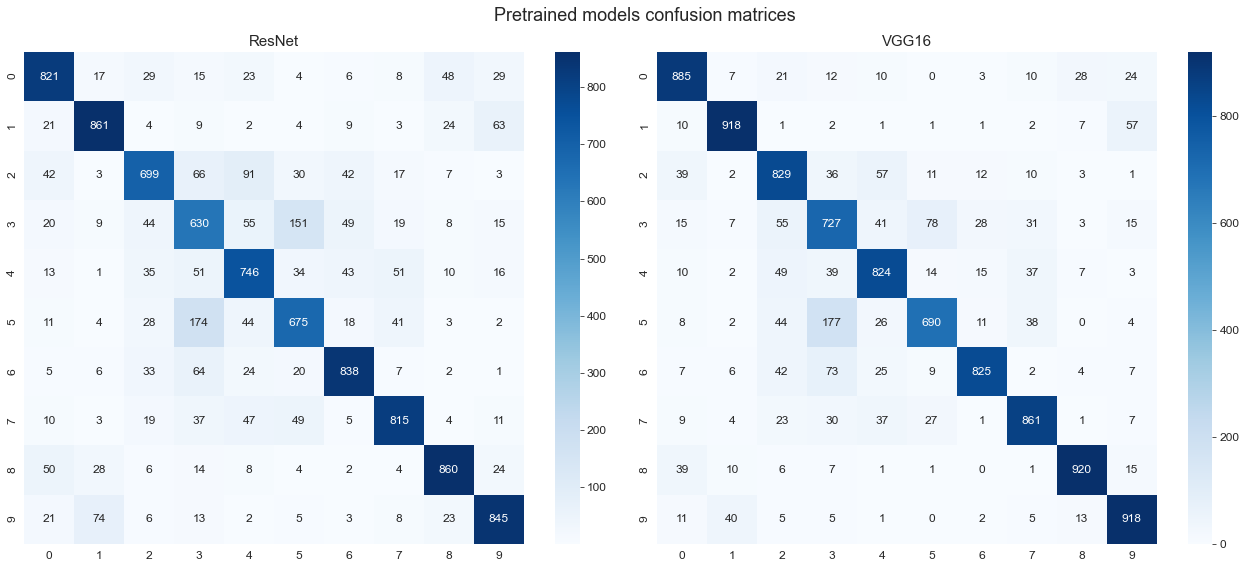

In [25]:
fig, axes = plt.subplots(1,2,figsize=(18,8))
models = ['ResNet', 'VGG16',]
models_results = [conf_matr_resnet, conf_matr_vgg]
title = "Pretrained models confusion matrices"
for i in range(2):
    sns.heatmap(models_results[i], annot=True, cmap="Blues", ax=axes[i], fmt='d', annot_kws={"size": 12})
    axes[i].set_title(models[i], size=15)
    axes[i].set_xticklabels(axes[i].get_xmajorticklabels(), fontsize = 12)
    axes[i].set_yticklabels(axes[i].get_xmajorticklabels(), fontsize = 12)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=12)

fig.suptitle(title, size=18)
plt.tight_layout()
plt.show()